## 3. Predicting Price with Neighborhood

In [1]:
# ! pip install category_encoders

In [2]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

### Import

In [3]:
def wrangle(filepath):
    df = pd.read_excel(filepath)

    # Subset data: houses 
    mask_house = df["property_type"] == "house"

    df = df[mask_house]

    # Remove outliers in "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon"
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand = True).astype(float)
    df.drop(columns = "lat-lon", inplace = True) # Drop the old column 

    # Extract neighborhood
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns = "place_with_parent_names", inplace = True)

    # Drop n/a 
    df.dropna(subset = ["price_aprox_usd", "neighborhood"], inplace = True)

    return df 

In [4]:
files = glob("data/real-estate-*.xlsx")
files

['data/real-estate-1.xlsx',
 'data/real-estate-5.xlsx',
 'data/real-estate-4.xlsx',
 'data/real-estate-3.xlsx',
 'data/real-estate-2.xlsx']

In [5]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)

In [6]:
df = pd.concat(frames, ignore_index=True)
print(df.shape)
df.head()

(9419, 16)


,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,lat,lon,neighborhood
0,sell,house,250000.0,USD,3790600.0,250000.0,117.0,120.0,2136.752137,2083.333333,NaN,4.0,NaN,NaN,NaN,La Matanza
1,sell,house,410000.0,USD,6216584.0,410000.0,410.0,220.0,1000.000000,1863.636364,NaN,NaN,NaN,-34.649700,-58.658073,Morón
2,sell,house,180000.0,USD,2729232.0,180000.0,200.0,135.0,900.000000,1333.333333,NaN,5.0,NaN,-34.595709,-58.566950,Tres de Febrero
3,sell,house,130000.0,USD,1971112.0,130000.0,300.0,140.0,433.333333,928.571429,NaN,NaN,NaN,-34.655209,-58.697320,Ituzaingó
4,sell,house,230000.0,USD,3487352.0,230000.0,290.0,230.0,793.103448,1000.000000,NaN,5.0,NaN,-34.652173,-58.577867,La Matanza


### Split

In [7]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

### Baseline

In [8]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean house price:", y_mean)
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean house price: 302556.3334770146
Baseline MAE: 144036.5743916468


### Iterate

In [9]:
# Instantiate
ohe = OneHotEncoder(use_cat_names=True)
# Fit
ohe.fit(X_train)
# Transform
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(9419, 80)


,neighborhood_La Matanza,neighborhood_Morón,neighborhood_Tres de Febrero,neighborhood_Ituzaingó,neighborhood_Presidente Perón,neighborhood_Tigre,neighborhood_Moreno,neighborhood_Lanús,neighborhood_Vicente López,neighborhood_General San Martín,...,neighborhood_Barrio Norte,neighborhood_Recoleta,neighborhood_Villa Soldati,neighborhood_Cañuelas,neighborhood_Villa Santa Rita,neighborhood_Pompeya,neighborhood_Monserrat,neighborhood_Parque Avellaneda,neighborhood_Constitución,neighborhood_Parque Centenario
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Use Ridge() to solve overfitting from high dimensionality 
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge())

model.fit(X_train, y_train)
print(model.fit(X_train, y_train))

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])


### Evaluate 

In [11]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 122533.66


### Communicate Results

In [12]:
# Extract the coefficients
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 80
[ -74392.81336589  -88466.54725955 -104786.79636603  -92523.47010847
  -61453.03920976]


In [13]:
# Get feature names 
feature_names = model.named_steps["onehotencoder"].get_feature_names_out()
print("features len:", len(feature_names))
print(feature_names[:5])  

features len: 80
['neighborhood_La Matanza' 'neighborhood_Morón'
 'neighborhood_Tres de Febrero' 'neighborhood_Ituzaingó'
 'neighborhood_Presidente Perón']


In [14]:
# Create a pandas Series named feat_imp where the indices are features and the values are your coefficients
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.sort_values(ascending=True).head()

neighborhood_Florencio Varela     -202455.698812
neighborhood_Marcos Paz           -165264.580305
neighborhood_Merlo                -153767.325321
neighborhood_José C Paz           -152007.082853
neighborhood_General San Martín   -143089.553057
dtype: float64

In [15]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 298262.66
+ (-74392.81 * neighborhood_La Matanza)
+ (-88466.55 * neighborhood_Morón)
+ (-104786.8 * neighborhood_Tres de Febrero)
+ (-92523.47 * neighborhood_Ituzaingó)
+ (-61453.04 * neighborhood_Presidente Perón)
+ (124335.16 * neighborhood_Tigre)
+ (-57754.1 * neighborhood_Moreno)
+ (-135618.68 * neighborhood_Lanús)
+ (22181.15 * neighborhood_Vicente López)
+ (-143089.55 * neighborhood_General San Martín)
+ (18947.78 * neighborhood_Villa General Mitre)
+ (-77110.12 * neighborhood_Lomas de Zamora)
+ (-43445.5 * neighborhood_Escobar)
+ (-85629.08 * neighborhood_Almirante Brown)
+ (82416.7 * neighborhood_San Isidro)
+ (9231.53 * neighborhood_San Fernando)
+ (105800.33 * neighborhood_)
+ (227970.39 * neighborhood_Nuñez)
+ (7269.71 * neighborhood_Flores)
+ (-93610.13 * neighborhood_Boca)
+ (-12952.26 * neighborhood_Pilar)
+ (-80306.57 * neighborhood_San Miguel)
+ (-86654.29 * neighborhood_General Rodríguez)
+ (34050.89 * neighborhood_Saavedra)
+ (234079.87 * neighborhood_Matadero

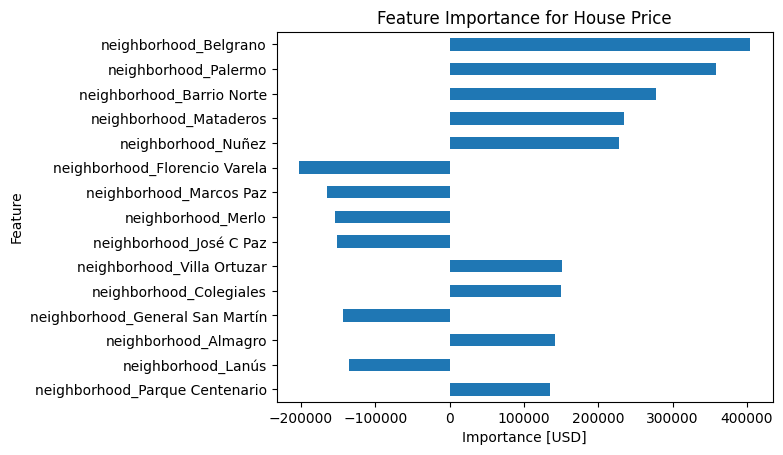

In [16]:
# Bar chart 
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh") # Sort by absolute values -> get the biggest 15 values in absolute terms
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for House Price");

plt.savefig("images/fig4.1_feature_importance.png", bbox_inches = "tight")

# Thus, being in the "Belgrano" neighborhood increases the house price by 404176.37 USD,
# while being in the "Florencio Varela" neighborhood decreases the house price by 202455.70 USD. 